# Summarization with blurr
> blurr is a libray I started that integrates huggingface transformers with the world of fastai v2, giving fastai devs everything they need to train, evaluate, and deploy transformer specific models.  In this article, I provide a simple example of how to use blurr's new summarization capabilities to train, evaluate, and deploy a BART summarization model.

*Updated on 08/21/2020 to use fastai 2.0.0 and also demo batch-time padding*.  
*Updated on 09/25/2020 to use on the fly batch-time tokenization*.  
*Updated on 11/12/2020 with support for fastai >= 2.1.5 and mixed precision*.
*Updated on 12/31/2020 (too much for one sentence, see the docs for more).*  
*Updated on 05/13/2022 (using blurr 1.0.x)*
- toc: false
- badges: true
- comments: true
- author: Wayde Gilliam
- categories: [fastai, huggingface, blurr, summarization, text generation]
- image: images/articles/blurr-logo-small.png
- hide: false
- search_exclude: false
- show_tags: true

In [ ]:
 # only run this cell if you are in collab
!pip install transformers -Uqq
!pip install datasets -Uqq
!pip install bert-score -Uqq
!pip install sacremoses
!pip install ohmeow-blurr -Uqq
!pip install contractions

     |████████████████████████████████| 4.7 MB 7.4 MB/s 
     |████████████████████████████████| 6.6 MB 33.8 MB/s 
     |████████████████████████████████| 120 kB 53.0 MB/s 
     |████████████████████████████████| 365 kB 7.8 MB/s 
     |████████████████████████████████| 115 kB 39.6 MB/s 
     |████████████████████████████████| 212 kB 35.9 MB/s 
     |████████████████████████████████| 127 kB 42.4 MB/s 
     |████████████████████████████████| 60 kB 3.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 880 kB 7.5 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=fef26ee5cd99b3c5997eadf05d0b15f774bff632b3760c2f5793742f04def77c
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
     |████████████████████████████████| 81 kB 5.3 MB/s 
     |█████████████████████████

In [ ]:
import datasets
import random
import pandas as pd
from fastai.text.all import *
from transformers import *
import contractions
from blurr.text.data.all import *
from blurr.text.modeling.all import *
import nltk
nltk.download('punkt', quiet=True)

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transcript='/content/drive/MyDrive/How2 Dataset/text/sum_train/tran.tok.txt'
summary='/content/drive/MyDrive/How2 Dataset/text/sum_train/desc.tok.txt'

In [ ]:
import re
transcripts=[]
summaries=[]

In [ ]:
n=1000

In [ ]:
with open(summary, "r") as file1:
    FileContent = file1.read()

    s=re.split(r"\n", FileContent)

for i in range(n):
  rs=""
  s[i] = re.sub(r'.', '', s[i], count = 11)
  expanded_words=[]
  for word in s[i].split():
      expanded_words.append(contractions.fix(word))
  expanded_text = ' '.join(expanded_words)
  words = re.findall(r'\w+', expanded_text.lower())
  rs= ' '.join(words)
  summaries.append(rs)

summaries[0:10]


['when choosing a martial art choose an informed and talented instructor choose a martial arts fighting system with tips from a martial arts teacher in this free self defense video',
 'using front layers as a guide cut back layers into curly hair learn to cut layers in curly hair with expert tips from a hairstylist in this free video about curly hairstyles',
 'the intonation on a guitar means a lot in its playability learn about all the facets that you can modify to adjust your guitar s action in this free video clip',
 'leveling out tracks is another way of evening out the sound learn how to level out beats in ultrabeat using logic 8 in this free music software video from a music studio owner and producer',
 'learn how to use a saw to cut gourds for decorative gourd art in this free online video arts and crafts lesson',
 'sparkling wines of spain produced in catalonia are called cava learn about spanish sparkling wines with tips from a sommelier in this free sparkling wine video',
 'm

In [ ]:
with open(transcript, "r") as file1:
    FileContent = file1.read()

    s=re.split(r"\n", FileContent)

for i in range(n):

  rs=""
  s[i] = re.sub(r'.', '', s[i], count = 11)
  expanded_words=[]
  for word in s[i].split():
      expanded_words.append(contractions.fix(word))
  expanded_text = ' '.join(expanded_words)
  words = re.findall(r'\w+', expanded_text.lower())
  rs= ' '.join(words)
  transcripts.append(rs)

transcripts[0:10]


['hi everybody i m john graden from the martial arts teacher s association and johngraden com one of the questions i have been asked through the years how do you choose a martial art it really varies it depends on what your goal is are you trying to get in better shape do you want to learn self defense do you want to compete or are you just interested in the mental benefits of the martial arts offer you mental benefits such as self confidence self discipline self control respect so there is a lot of variables in my mind when people say what style is best what style should i do the only style that is really important is the teaching style of the instructor so how do you choose a good martial arts it is really more about choosing a good martial arts instructor it s about choosing a good martial arts school so when you are going to make the decision make sure first you know what your goal is if you really want a strong self defense oriented system you want to be working with an instructor

In [ ]:
print(len(transcripts),len(summaries))

1000 1000


In [ ]:
articles=transcripts
summary=summaries

In [ ]:
import re
def getLength(art):
  res = len(re.findall(r'\w+', art))
  return res

In [ ]:
len_art=[]
len_sum=[]
for i in articles:
  len_art.append(getLength(i))
for i in summary:
  len_sum.append(getLength(i))

In [ ]:
max(len_art)

956

In [ ]:
max(len_sum)

68

In [ ]:
avg_art=sum(len_art)/len(len_art)
avg_sum=sum(len_sum)/len(len_sum)

In [ ]:
print(avg_art,avg_sum)

256.237 31.082


In [ ]:
import numpy as np
import pandas as pd
train=[]
test=[]
for i in range(n):
  train.append(np.array([articles[i],summary[i]]))
df_train = pd.DataFrame(train, columns = ['Transcript','Summary'])
print(type(df_train))
df_train.head()

<class 'pandas.core.frame.DataFrame'>


,Transcript,Summary
0,hi everybody i m john graden from the martial arts teacher s association and johngraden com one of the questions i have been asked through the years how do you choose a martial art it really varies it depends on what your goal is are you trying to get in better shape do you want to learn self defense do you want to compete or are you just interested in the mental benefits of the martial arts offer you mental benefits such as self confidence self discipline self control respect so there is a lot of variables in my mind when people say what style is best what style should i do the only style...,when choosing a martial art choose an informed and talented instructor choose a martial arts fighting system with tips from a martial arts teacher in this free self defense video
1,we are going to continue with the remainder of her quadrants which is quadrant no 4 and this is the section right here i m going to use a little bit of water it s very important that you keep the hair moist because the hair stretches so what we are going to do with this section is we are going to do the exact same thing that we did with quadrant no 1 okay i m going to place shelly facing me i m going to take my first subsection brush her hair down comb it down bring it straight up and the section that i m going to use as a guide will be the one from quadrant no 1 bring it straight up remem...,using front layers as a guide cut back layers into curly hair learn to cut layers in curly hair with expert tips from a hairstylist in this free video about curly hairstyles
2,so we ve determined that we are a little bit sharp and it s due to the thickness of the string so we want to make that adjustment we wanted this the harmonic to match that the adjustment is made usually through the end of the bridge and test it still sharp still sharp i have shifted it too much we will go back the other way it will go a little flat almost a little bit more maybe another half a turn boy that s about as close as we are going to be able to get it saying a little sharp a little flat now it s a little flat keep making adjustments until the two until the two work together this j...,the intonation on a guitar means a lot in its playability learn about all the facets that you can modify to adjust your guitar s action in this free video clip
3,the next thing we are going to do is we are going to level out our tracks we are going to put it where it should be and try to level out the drums somewhere what i m going to do is i m going to try my kick and just try to even it out a little bit more maybe turn on my snare a little bit too and maybe change the high hat just a little bit then i will be going like that now once you have these all set just make sure that they are all going out to the same thing you could also do things like pan them out right here mute and solo and highlight any tracks you can also arrange the outputs as wel...,leveling out tracks is another way of evening out the sound learn how to level out beats in ultrabeat using logic 8 in this free music software video from a music studio owner and producer
4,on behalf of expert village my name is karen locasale and i am here to tell you about crafting with gourds so there is our pilot hole and this will allow you to either put a craft knife in here or in my case i am going to use a jig saw so once you get it cut the way you like it you can also use sand paper to take off those rough edges and you know change your design or whatever it is you are going to do if you like it the way it is perfect i did n t mention before hand but this particular bowl i had a large crack down the side of it so i just when with below the crack so instead of the bow...,learn how to use a saw to cut gourds for decorative gourd art in this free online video arts and crafts lesson


In [ ]:
# for i in range(len(articles_test)):
#   test.append(np.array([articles_test[i],summary_test[i]]))

# df_test = pd.DataFrame(test, columns = ['Transcript','Summary'])


# print(type(df_test))
# df_test.head()

In [ ]:
print(len(df_train))

1000


## Data Preparation

We're going to use to use the  [datasets](https://huggingface.co/datasets) library from huggingface to grab your raw data.  This package gives you access to all kinds of NLP related datasets, explanations of each, and various task specific metrics to use in evaluating your model.  The best part being everything comes down to you in JSON!  This makes it a breeze to get up and running quickly!

We'll just use a subset of the training set to build both our training and validation DataLoaders

We begin by getting our hugginface objects needed for this task (e.g., the architecture, tokenizer, config, and model).  We'll use blurr's `get_hf_objects` helper method here.

In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)
hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

Next we need to build out our DataBlock.  Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable.  That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice that the blurr DataBlock as been dramatically simplified given the shift to on-the-fly batch-time tokenization.  All we need is to define a single `Seq2SeqBatchTokenizeTransform` instance, optionally passing a list to any of the tokenization arguments to differentiate the values for the input and summary sequences.  In addition to specifying a custom max length for the inputs, we can also do the same for the output sequences ... and with the latest release of blurr, we can even customize the text generation by passing in `text_gen_kwargs`.

We pass `noop` as a type transform for our targets because everything is already handled by the batch transform now.

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization');
text_gen_kwargs

{'max_length': 142,
 'min_length': 56,
 'do_sample': False,
 'early_stopping': True,
 'num_beams': 4,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'typical_p': 1.0,
 'repetition_penalty': 1.0,
 'bad_words_ids': None,
 'bos_token_id': 0,
 'pad_token_id': 1,
 'eos_token_id': 2,
 'length_penalty': 2.0,
 'no_repeat_ngram_size': 3,
 'encoder_no_repeat_ngram_size': 0,
 'num_return_sequences': 1,
 'decoder_start_token_id': 2,
 'use_cache': True,
 'num_beam_groups': 1,
 'diversity_penalty': 0.0,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'return_dict_in_generate': False,
 'forced_bos_token_id': 0,
 'forced_eos_token_id': 2,
 'remove_invalid_values': False,
 'exponential_decay_length_penalty': None}

In [ ]:
hf_batch_tfm = Seq2SeqBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, max_length=max(len_art), max_tgt_length=max(len_sum), text_gen_kwargs=text_gen_kwargs
)

blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=hf_batch_tfm), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('Transcript'), get_y=ColReader('Summary'), splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(df_train, bs=2)

In [ ]:
len(dls.train.items), len(dls.valid.items)

(800, 200)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 956]), torch.Size([2, 39]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.  We pass in the `dls` via the `dataloaders` argument so we can access all tokenization/modeling configuration stored in our batch transform above.

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

## Training

We'll prepare our BART model for training by wrapping it in blurr's `BaseModelWrapper` object and using the callback, `BaseModelCallback`, as usual.  A new `Seq2SeqMetricsCallback` object allows us to specify Seq2Seq metrics we want to use, things like rouge and bertscore for tasks like summarization as well as metrics such as meteor, bleu, and sacrebleu for translations tasks. Using huggingface's metrics library is as easy as specifying a metrics configuration such as below.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable.  See [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training) for our discriminitative learning rates work in fastai.

**Note:** This has been tested with ALOT of other Seq2Seq models; see the docs for more information.

In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [ ]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls,
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(blurr_seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt()
learn.freeze()

Still experimenting with how to use fastai's learning rate finder for these kinds of models.  If you all have any suggestions or interesting insights to share, please let me know.  We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(valley=6.30957365501672e-05)

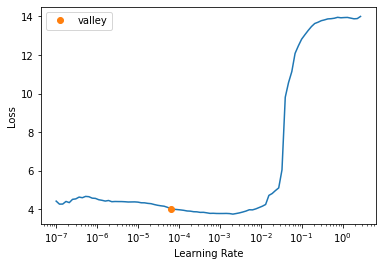

In [ ]:
learn.lr_find()

It's also not a bad idea to run a batch through your model and make sure the shape of what goes in, and comes out, looks right.

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

NameError: ignored

In [ ]:
learn.fit_one_cycle(10, lr_max= 1.9054606673308001e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time


And now we can look at the generated predictions using our `text_gen_kwargs` above

In [ ]:
learn.show_results(learner=learn, max_n=2)

Even better though, blurr augments the fastai Learner with a `blurr_summarize` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [ ]:
test_article = """
The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline
crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107.
"""

We can override the `text_gen_kwargs` we specified for our `DataLoaders` when we generate text using blurr's `Learner.blurr_generate` method

In [ ]:
outputs = learn.blurr_summarize(test_article, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

What about inference?  Easy!

In [ ]:
learn.metrics = None
learn.export(fname='ft_cnndm_export.pkl')

In [ ]:
inf_learn = load_learner(fname='ft_cnndm_export.pkl')
# x=inf_learn.blurr_summarize(test_article)

In [ ]:
outputs = inf_learn.blurr_generate(test_article, early_stopping=False, num_return_sequences=1)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

In [ ]:
# x[0]['summary_texts']

In [ ]:
# a = list(outputs[0].values())
# a[0]

In [ ]:
pred_summary = []
for i in range(50):
  outputs = inf_learn.blurr_generate(articles[500+i], early_stopping=False, num_return_sequences=1)
  a = list(outputs[0].values())
  pred_summary.append(a[0])

In [ ]:
len(pred_summary )

In [ ]:
pred_summary[0]

In [ ]:
# summary_test[0]

In [ ]:
# articles_test[0]

# Computing Scores

In [ ]:
!pip install rouge_score

In [ ]:
from datasets import load_dataset, load_metric
rouge = load_metric('rouge')

In [ ]:
def computeScore(score):
  precision = []
  recall = []
  f1 = []
  for i in range(200):
      result = rouge.compute(predictions=[pred_summary[i]], references=[summary[800+i]])
      precision.append(result[score].high.precision)
      recall.append(result[score].high.recall)
      f1.append(result[score].high.fmeasure)
  pavg = sum(precision)/len(precision)
  print("_______",score,"____________")
  print('Precision:', pavg)

  ravg = sum(recall)/len(recall)
  print('Recall', ravg)

  favg = sum(f1)/len(f1)
  print('F1- Score', favg)
  plotGraph(precision,recall,f1,score)
  print("______________________________")

In [ ]:
indices=[i for i in range(200)]
def plotGraph(precision,recall,f1,score):
  plt.plot(indices, precision, label = "precision")
  plt.plot(indices, recall, label = "recall")
  plt.plot(indices, f1, label = "f1-score")
  plt.xlabel('id')
  plt.ylabel('score')
  plt.title('ROUGE Score')
  plt.savefig(score)

In [ ]:
computeScore('rouge1')

In [ ]:
computeScore('rouge2')

In [ ]:
computeScore('rougeLsum')

# That's it

[blurr](https://ohmeow.github.io/blurr/) supports a number of huggingface transformer model tasks in addition to summarization (e.g., sequence classification , token classification, and question/answering, causal language modeling, and transation). The docs include examples for each of these tasks if you're curious to learn more.

For more information about ohmeow or to get in contact with me, head over to [ohmeow.com](ohmeow.com) for all the details.

Thanks!

In [ ]:
!pip install pytube
!pip install pysrt
!pip install moviepy

In [ ]:
pip install SpeechRecognition

In [ ]:
pip install imageio_ffmpeg

In [ ]:
pip install noisereduce

In [ ]:
pip install pydub

In [ ]:
from moviepy.video.io.VideoFileClip import VideoFileClip as mp

In [ ]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import pytube, pysrt
# import moviepy.editor as mp
import speech_recognition as sr
from transformers import pipeline, TFAutoModelWithLMHead, AutoTokenizer
from pydub import AudioSegment
from pydub.silence import split_on_silence
from datasets import load_dataset, load_metric
from scipy.io import wavfile
import noisereduce as nr

In [ ]:
url = input("Please enter a YouTube URL:")
youtube = pytube.YouTube(url)

In [ ]:
pip install youtube_transcript_api

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi

In [ ]:
_id = url.split("=")[1].split("&")[0]

In [ ]:
# try:
#   YouTubeTranscriptApi.get_transcript(_id)
# else:


In [ ]:
# if(youtube.captions.get_by_language_code('en')):

try:
    # YouTubeTranscriptApi.get_transcript(_id)

    # video = youtube.streams.first()
    # print(video)
    # print('Downloading Video.....')
    # video.download(filename='fyp')
    # print('Video Downloaded')
    # print("Caption Available....")
    # en_caption = youtube.captions.get_by_language_code('en')
    # # print(en_caption.xml_captions)
    # # xml_caption = xml_caption_to_srt(en_caption.xml_captions)
    # # en_caption_convert_to_srt=xml_caption_to_srt(en_caption.xml_captions)
    # # print(ElementTree.tostring(en_caption.xml_captions))
    # tree =ElementTree.parse(en_caption.xml_captions)
    # root = tree.getroot()
    # for description in root.iter('p'):
    #     print(description.text)
    # en_caption_convert_to_srt = ElementTree.tostring(en_caption.xml_captions, encoding='unicode')
    # # en_caption_convert_to_srt =(en_caption.generate_srt_captions())
    # #print(en_caption_convert_to_srt)
    # #save the caption to a file named Output.txt
    # text_file = open("fyp.srt", "w")
    # text_file.write(en_caption_convert_to_srt)
    # text_file.close()
    # subs = pysrt.open("fyp.srt")
    # text_file1 = open("fyp.txt","w")
    # for sub in subs:
    #     print(sub.text)
    #     #text_file1 = open(path, "a")
    #     text_file1.write(sub.text)
    # text_file1.close()
    # _id = url.split("=")[1].split("&")[0]
    # transcript = YouTubeTranscriptApi.get_transcript(_id)
    # textTrans=""
    # for i in transcript:
    #   textTrans=textTrans+i["text"]

    # transcript = YouTubeTranscriptApi.get_transcript(_id)
    # script = ""

    # for text in transcript:
    #     t = text["text"]
    #     if t != '[Music]':
    #         script += t + " "
    input_text=generate_transcript(url)


except:
    print("There are no Captions!!!!")
    video = youtube.streams.first()
    print(video)
    print('Downloading.....')
    video.download(filename='fyp')
    print('Downloaded')
    clip = mp(r"/content/fyp")
    clip.audio.write_audiofile(r"fyp.wav")
    r = sr.Recognizer()
    def get_large_audio_transcription(path):
      sound = AudioSegment.from_wav(path)
      chunks = split_on_silence(sound,
          min_silence_len = 500,
          silence_thresh = sound.dBFS-14,
          keep_silence=500,
      )
      folder_name = "audio-chunks"
      if not os.path.isdir(folder_name):
          os.mkdir(folder_name)
      whole_text = ""
      for i, audio_chunk in enumerate(chunks, start=1):
          chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
          audio_chunk.export(chunk_filename, format="wav")
          with sr.AudioFile(chunk_filename) as source:
              audio_listened = r.record(source)
              try:
                  text = r.recognize_google(audio_listened
                                            # ,language='hi-In'
                                            )
              except sr.UnknownValueError as e:
                  print("Error:", str(e))
              else:
                  text = f"{text.capitalize()}."
                  print(chunk_filename, ":", text)
                  whole_text += text
      return whole_text
    path = "fyp.wav"
    text = get_large_audio_transcription(path)
    f = open("fyp.txt", "w")
    f.write(text)
    f.close()
    f = open("fyp.txt", "r", encoding="utf8")
    with open('fyp.csv', 'w', newline='', encoding="utf8") as file:
      writer = csv.writer(file)
      writer.writerow(["text"])
      writer.writerow([f.read()])
    df1 = pd.read_csv('fyp.csv')
    input_text = df1['text'][0]
# # load data
# rate, data = wavfile.read(path)
# # perform noise reduction
# reduced_noise = nr.reduce_noise(y=data, sr=rate)
# wavfile.write("fyp2.wav", rate, reduced_noise)
# path="fyp2.wav"

In [ ]:
# path = "fyp.wav"
# # load data
# rate, data = wavfile.read(path)
# # perform noise reduction
# reduced_noise = nr.reduce_noise(y=data, sr=rate)
# wavfile.write("fyp2.wav", rate, reduced_noise)
# path="fyp2.wav"
# text = get_large_audio_transcription(path)
# f = open("fyp.txt", "w")
# f.write(text)
# f.close()

In [ ]:
# f = open("fyp.txt", "r", encoding="utf8")
# with open('fyp.csv', 'w', newline='', encoding="utf8") as file:
#   writer = csv.writer(file)
#   writer.writerow(["text"])
#   writer.writerow([f.read()])
# df1 = pd.read_csv('fyp.csv')

In [ ]:
# input_text = df1['text'][0]
input_text

In [ ]:
# !pip install googletrans==3.1.0a0

In [ ]:
# import googletrans
# from googletrans import Translator
# translator = Translator()
# result = translator.translate(input_text)
# result.text

In [ ]:
# cvtart = result.text
cvtart=input_text
outputs = inf_learn.blurr_generate(cvtart, early_stopping=False, num_return_sequences=1)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

In [ ]:
# a = list(outputs[0].values())
# print(a[0])

In [ ]:
# result = translator.translate(a[0], src='en', dest='hi')
# print(result.text)

In [ ]:
# !pip install pytube
# !pip install pysrt
# !pip install SpeechRecognition
# !pip install pydub
# !pip install noisereduce

In [ ]:
!pip install gradio

In [ ]:
!pip install youtube_transcript_api

In [ ]:
# import gradio as gr
# from gradio.mix import Series
# from youtube_transcript_api import YouTubeTranscriptApi

# def generate_transcript(url):
#     _id = url.split("=")[1].split("&")[0]

#     transcript = YouTubeTranscriptApi.get_transcript(_id)
#     script = ""

#     for text in transcript:
#         t = text["text"]
#         if t != '[Music]':
#             script += t + " "

#     return script

# transcriber = gr.Interface(generate_transcript, 'text', 'text')
# summarizer = gr.Interface.load("huggingface/sshleifer/distilbart-cnn-12-6")

# gradio_ui = Series(transcriber, summarizer,
#                   inputs = gr.inputs.Textbox(label = "Enter the YouTube URL below:"),
#                   outputs = gr.outputs.Textbox(label = "Transcript Summary"),
#                   examples = ["https://www.youtube.com/watch?v=Cu3R5it4cQs&list", "https://www.youtube.com/watch?v=HB4I2CgkcCo"],
#                   title = "YouTube Transcript Summarizer",
#                   theme = "peach",
#                   description = "This application uses the sshleifer/distilbart-cnn-12-6 model to summarize a short YouTube video that has English subtitles. For it to work, the input URL must follow the format similar to the given examples, specifically having the video's ID at the end. Examples are videos from GCFLearnFree.org YouTube Channel."
#                    )

# gradio_ui.launch()

In [ ]:
import gradio as gr
from gradio.mix import Series
from youtube_transcript_api import YouTubeTranscriptApi

def generate_transcript(url):
    _id = url.split("=")[1].split("&")[0]

    transcript = YouTubeTranscriptApi.get_transcript(_id)
    script = ""

    for text in transcript:
        t = text["text"]
        if t != '[Music]':
            script += t + " "

    return script

transcriber = gr.Interface(generate_transcript, 'text', 'text')
summarizer = gr.Interface.load("huggingface/sshleifer/distilbart-cnn-12-6")

gradio_ui = Series(transcriber, summarizer,
                  inputs = gr.inputs.Textbox(label = "Enter the YouTube URL below:"),
                  outputs = gr.outputs.Textbox(label = "Transcript Summary"),
                  examples = ["https://www.youtube.com/watch?v=Cu3R5it4cQs&list", "https://www.youtube.com/watch?v=HB4I2CgkcCo"],
                  title = "YouTube Transcript Summarizer",
                  theme = "peach",
                  description = "This application uses the sshleifer/distilbart-cnn-12-6 model to summarize a short YouTube video that has English subtitles. For it to work, the input URL must follow the format similar to the given examples, specifically having the video's ID at the end. Examples are videos from GCFLearnFree.org YouTube Channel."
                   )

gradio_ui.launch()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
indices=[i for i in range(11)]
rouge1=[0.15,0.389,0.388,0.4257,0.4206,0.4252,0.4228,0.4165,0.4282,0.4249,0.4220]
rouge2=[0.15,0.1746,0.1710,0.191256,0.187484,0.1897,0.1854,0.1792,0.1873,0.1830,0.1817]
rougeL=[0.15,0.2852,0.2866,0.3036,0.3055,0.3060,0.3113,0.3082,0.3096,0.3113,0.3082]
precision=[0.15,0.8786,0.8754,0.8762,0.8774,0.8783,0.8749,0.8752,0.8770,0.8752,0.8748]
recall=[0.15,0.8866,0.8862,0.8962,0.8961,0.8966,0.8983,0.8973,0.8987,0.8977,0.8978]
f1=[0.15,0.8825,0.8806,0.8860,0.8865,0.8873,0.8864,0.8860,0.8876,0.8862,0.8860]
def plotGraph(rouge1,rouge2,rougeL,precision,recall,f1):
  plt.plot(indices, rouge1, label = "rouge1")
  plt.plot(indices, rouge2, label = "rouge2")
  plt.plot(indices, rougeL, label = "rougeL")
  plt.plot(indices, precision, label = "precision")
  plt.plot(indices, recall, label = "recall")
  plt.plot(indices, f1, label = "f1-score")
  # plt.xlim(0,20)
  plt.ylim(0.15,0.95)
  plt.xlabel('epoch')
  plt.ylabel('score')
  plt.title('ROUGE and Bert score')
  # plt.legend(["rouge1", "rouge2","rougeL","precision","recall","f1-score"], loc ="right",ncol=2)
  # plt.legend(bbox_to_anchor =(0.87, -0.2),loc="upper right", ncol = 1)
  plt.legend(bbox_to_anchor=(1.28,1.03), loc='upper right')

  plt.savefig('score')

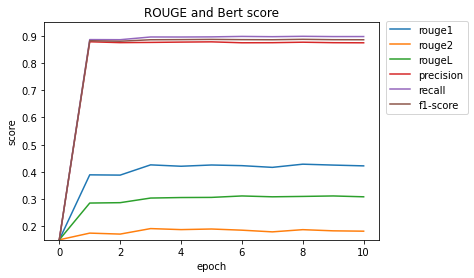

In [ ]:
plotGraph(rouge1,rouge2,rougeL,precision,recall,f1)